In [5]:
import scipy
import numpy as np
import pandas as pd
import itertools as it
from random import shuffle
from math import sin
import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import scale

from scipy.stats.stats import pearsonr 

from scipy.stats import invgamma 
from scipy.stats import beta
import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib.collections import BrokenBarHCollection
import re

from Lab_modules.Modules_tools import *

init_notebook_mode(connected=True)

# Overlap and classification of haploid populations.

In post _7_ we developed a function to measure the overlap of the distributions of three-dimensional point clouds.

In this post we will apply the same approach to the PCA projection of Wright-Fisher haploid populations at varying genetic distances.

- Post _8. Controlling for size_, explores the relation between Fst and euclidian distances calculated in PCA feature space.

We begin by generating a base data set of vectors of draws from the beta distribution (bi-allelic equivalent of the dirichlet distribution, see [Balding & Nichols 1995](https://link.springer.com/article/10.1007/BF01441146)). These vectors are created at varying combinations of mean and variance parameters of the beta distribution.

Length is determined in the next bock.

In order to ensure the simulation of populations along a continuous range of distances we will resort to the inverse transformation of new coordinates in the feature space of the PCA of the base vector data set.

### Index

This post is divided into two sections, representing two approaches to measuring overlap between reference distributions.

#### A. Collision.

In this section the overlap of populations is induced through the selection of vectors along a range of genetic distances. This is done by generating a number of new coordinates between the projections of two initially selected vectors, inverse transforming them, and using the result to produce haplotype populations.

The number of populations generated, their sample size, and their group assignment is defined in the next block.

#### B. Frequency. 

This section explores ditribution overlap at a single cluster. The consequences of the relative frequency of reference accessions at one place on overall error and classification.



In [6]:
# Simulate frequency vectors. 
# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 150

import itertools as it
n= 200

# Vary a (beta distribution parameter).
a_range= np.linspace(1,2,20)
a_set= [i for i in a_range for _ in range(n)]

# vary b.
b_range= np.linspace(0.1,.4,20)
b_set= [i for i in b_range for _ in range(n)]

## length of haplotypes to extract.
L_set= [L] * n * 20


background_1= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background_1.shape[0]):
    
    probs= beta.rvs(background_1[k,0], background_1[k,1], size=int(background_1[k,2]))
    probs[(probs > 1)]= 1
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)

In [7]:
print('Number of frequency vectors of size {} generated: {}'.format(vector_lib.shape[1],vector_lib.shape[0]))


Number of frequency vectors of size 150 generated: 4000


In [8]:
## PCA on vectors simulated
n_comp = 100

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)# * pca.explained_variance_ratio_

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.019; PC2: 0.009; PC3: 0.009; PC4: 0.009; PC5: 0.009; PC6: 0.009; PC7: 0.009; PC8: 0.009; PC9: 0.009; PC10: 0.009; PC11: 0.009; PC12: 0.009; PC13: 0.008; PC14: 0.008; PC15: 0.008; PC16: 0.008; PC17: 0.008; PC18: 0.008; PC19: 0.008; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.008; PC30: 0.008; PC31: 0.008; PC32: 0.008; PC33: 0.008; PC34: 0.008; PC35: 0.008; PC36: 0.008; PC37: 0.008; PC38: 0.008; PC39: 0.008; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.007; PC45: 0.007; PC46: 0.007; PC47: 0.007; PC48: 0.007; PC49: 0.007; PC50: 0.007; PC51: 0.007; PC52: 0.007; PC53: 0.007; PC54: 0.007; PC55: 0.007; PC56: 0.007; PC57: 0.007; PC58: 0.007; PC59: 0.007; PC60: 0.007; PC61: 0.007; PC62: 0.007; PC63: 0.007; PC64: 0.007; PC65: 0.007; PC66: 0.007; PC67: 0.007; PC68: 0.007; PC69: 0.007; PC70: 0.007; PC71: 0.006; PC72: 0.006; PC73: 0.006; PC74: 0.006; PC75: 0.006; PC76: 0.006; PC77: 0.006; PC78: 0.

In [10]:
## Plot vector PCA
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background_1[k,0],background_1[k,1],background_1[k,2], k) for k in range(background_1.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 2,
        'symbol': 'circle',
      "opacity": .6
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data)
iplot(fig)


### Defining functions 

This Section will eventually be exported to its own script.

The next block defines the functions that extract Fsts between population vectors, that meassure overlap between 3D coordinates and measure and return normalized KDE measures from euclidian coordinates.

The  next block defines the functions that process that data.

**Merge_class()** and **Merge_class_mix()** return the classification of observations across data sets based on provided thresholds;

**compress_ideo()** reshapes the classificaiton output;

**return_ideo()** plots the compressed classification output in the form of ideogram representations using matplotlib.



## A. Collision

### Preparing populations.

The process of generating haplotype populations is the same used in the _10. Admixed populations_.

The population of source of any given haplotype generated will be pre-determined in the form of a vector of probabilities summing to one. In effect these values constitute their admixture proportions.

For the present simulations probabilities are binary. Reference and admixed haplotypes will be consistently assigned to the same vectors.

In [45]:
Mix_sizes= False

labels= [0,1,0]
target= [0,1,0]

Sizes= [50,150,100]

Origins= {
    x:{
        y:[int(z == x) for z in range(len(Sizes))] for y in range(Sizes[x])
    } for x in range(len(Sizes))
}

import random

Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]
"""
Origins[len(Sizes) - 1]= {
    y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
}
"""

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}

d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        d += 1


In [46]:
from IPython.display import clear_output

Euclidian_range= np.arange(0,10,.1)

label_vector= np.repeat(labels,Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}
target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}

Pops= np.random.choice(vector_lib.shape[0],len(Sizes),replace= False)

label_vector_bl= recursively_default_dict()
label_indicies_bl= recursively_default_dict()
target_indx_bl= recursively_default_dict()


Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 1e-3


Windows= recursively_default_dict()
Windows_class= recursively_default_dict()

Windows_union= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

PCs= [0,1,2]

pc_density= {x:[] for x in PCs}
pc_coords= {x:[] for x in PCs}

threshold= .005
P= 30

current= recursively_default_dict()


for angle in Euclidian_range:
    print(angle)
    if Mix_sizes:
        Sizes= np.random.choice(range(50,200),len(Sizes))

        Origins= {
            x:{
                y:[int(z == x) for z in range(len(Sizes))] for y in range(Sizes[x])
            } for x in range(len(Sizes))
        }

        import random

        Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]
        """
        Origins[len(Sizes) - 1]= {
            y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
        }
        """

        #### we can store these in a way that will facilitate later requests:
        Whose= []
        ind_to_group= {}

        d= 0

        for gp in Origins.keys():
            for acc in range(len(Origins[gp])):
                Whose.append(d)
                ind_to_group[d]= [gp,acc]
                d += 1
        label_vector= np.repeat(labels,Sizes)
        label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}
        target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
    
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    #new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    N_pops= len(Pops)
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]

    data= []
    local_labels= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(range(new_freqs.shape[0]), p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(range(new_freqs.shape[0]), p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_chr'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(labels[k] + 1)
    
    data= np.array(data)
    
    print(data.shape)
    
    if not Mix_sizes:
        for hap in range(data.shape[0]):
            haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')
    
    data= pca2.fit_transform(data)
    profiles_union= extract_profiles_union(data,label_indicies,threshold,P)

    profiles_class= extract_profiles_class(data,label_indicies)
    
    ##### PC density
    for PC in PCs:

        pc_places= data[:,PC]

        X_plot = np.linspace(-4, 4, 100)

        kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(np.array(pc_places).reshape(-1,1))

        log_dens= kde.score_samples(X_plot.reshape(-1,1))

        pc_density[PC].append(np.exp(log_dens))
        pc_coords[PC].append(pc_places)
    
    ##### FSTs
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([angle] * Pairwise.shape[0])

    ### store stuff.
    label_vector_bl[bl]= label_vector
    label_indicies_bl[bl]= label_indicies
    target_indx_bl[bl]= target_indx
    
    Windows_class[bl]= profiles_class
    Blocks[1][bl]= local_labels
    Windows_union[bl]= profiles_union
    
    clear_output()

Windows_class= {1:Windows_class}


### Simulation overview

We analyse the combinations of Fsts produced during our simulations.

In [52]:
x_coords= [z for z in it.chain(*[[x] * 100 for x in range(len(pc_coords[1]))])]
y_coords= [z for z in it.chain(*[list(np.linspace(-4,4,100)) for x in range(len(pc_density[1]))])]

#x_coords= [z for z in it.chain(*pc_coords[0])]
#y_coords= [z for z in it.chain(*pc_coords[0])]
z_coords= [z for z in it.chain(*pc_density[0])]


fig_data= [go.Scatter(
x= x_coords,
y= y_coords,
mode= 'markers',
marker= {
    'color': z_coords,
    'colorscale':'Viridis',
    'line': {'width': 0},
    'size': 7,
    'symbol': 'circle',
    "opacity": .6
})
]

layout = go.Layout(
    title= 'PC1 density',
    yaxis=dict(
        title='PC1 density of projections across data sets'),
    xaxis=dict(
        title='Ideogram')
)


fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [51]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two



labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []


for angle in Euclidian_range:
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    #new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0

    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    labels.extend(Pairwise.pops)
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T


coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= Control[coords[i],0],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts as a function of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Genetic-data-analysis\Notebooks\Lab_modules\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars



**Fig. Simulated Fsts** pairwise Fsts between all population vectors used and across across data sets.

In [53]:
# Plot overlaps

fst_indexes= {z:[x for x in range(len(Fst_labels)) if Fst_labels[x] == z] for z in list(set(Fst_labels))}
fst_target= [z for z in fst_indexes.keys() if len([x for x in target if x in z]) == len(target)][0]

tup= '01'
Xs= []
pop1= []
labels= []

for window in Windows_union.keys():
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])

coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T

fig_data= [go.Scatter(
x= [Fst_crawl[x] for x in fst_indexes[fst_target]],
y= datum[coords[i],1],
mode= 'lines',
name= i
) for i in coords.keys()
]
layout = go.Layout(
    title= 'Variation between. Unimodal',
    yaxis=dict(
        title= 'volume'
        #range=[0, 1]
    ),
    xaxis= dict(
        title= 'Fst'
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)

**Fig. Distribution overlap** Overlap between reference distributions as a function  of the genetic proximity of the two "colliding" substructures.

## Ideogram output

The first ideogram produced displays the vector of origin of each haplotype across data sets.

The remaining ideograms display the classificaiton of those haplotypes according to reference distributions with adjustable _p_-value comparison threshold. The first ideogram is plotted with a threshold of **1**, effectively assigning haplotypes to the population providing the highest _p_-value.

adding ideograms...


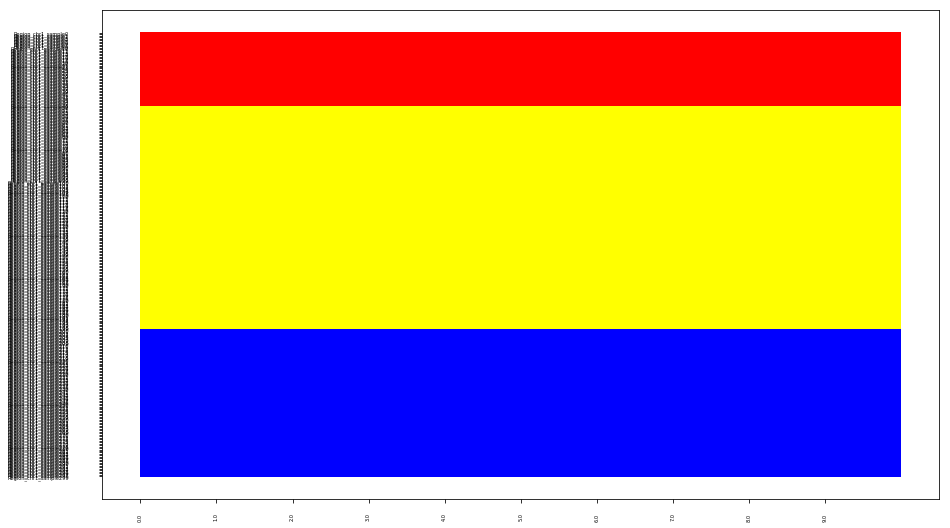

In [54]:
Comparison_threshold= 1
Outlier_threshold= 1e-4
from Lab_modules.Lab_ideogram_tools_II import return_ideogram, compress_ideo

if not Mix_sizes:
    Ideo_KDE = []
    chromosome_list= []
    chromosomes= Blocks.keys()

    for here in range(len(label_vector)):
        Subject = 'sample' + str(here)

        chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

        Stock = [[['Region_chr'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
        Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]

        Ideo_KDE.extend(Stock)

    #### begin by compressing assignments by individuals. Lightens the load of the following plot.
    import re
    ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

    # Filter out chromosomes not in our list
    ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

    ideo = compress_ideo(ideo,chromosome_list,Out)
    fig= return_ideogram(ideo,chromosome_list,'truth',height=9,width= 15)


#### Ideogram Origins

1
number of reference populations: 2
adding ideograms...


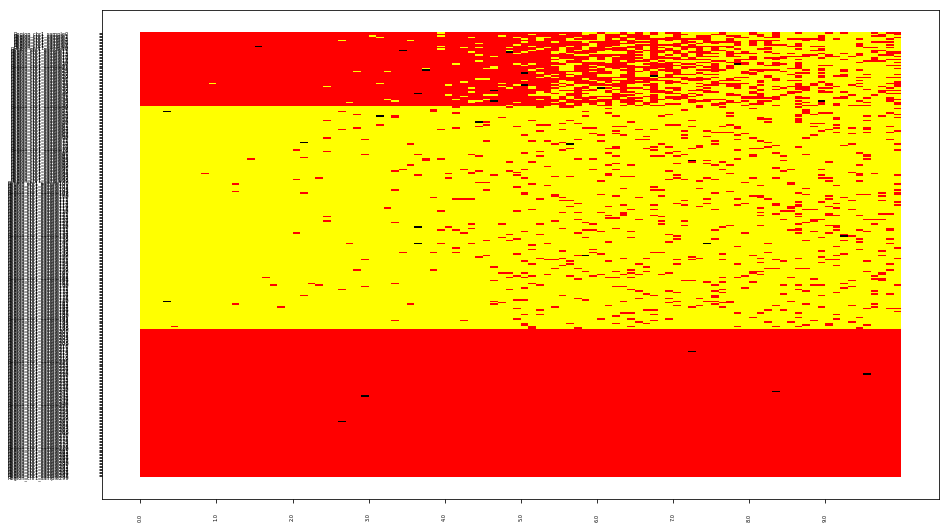

In [56]:
#### KDE no filter

import re
chromosome_list= [] 
chromosomes= [1]

Comparison_threshold= 1
Outlier_threshold= 1e-4

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])



focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 1
Outlier_threshold= 1e-4

color_ref= ['red','yellow','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class_mix(Windows_class,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

if not Mix_sizes:
    Ideo_KDE = []
    chromosome_list= []
    chromosomes= Blocks.keys()

    for here in range(len(label_vector)):
        Subject = 'sample' + str(here)

        chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

        Stock = [[['Region_chr'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
        Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]

        Ideo_KDE.extend(Stock)

    #### begin by compressing assignments by individuals. Lightens the load of the following plot.
    import re
    ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

    # Filter out chromosomes not in our list
    ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

    ideo_kde = compress_ideo(ideo_kde,chromosome_list,Out)

    fig= return_ideogram(ideo_kde,chromosome_list,'kde',height=9,width= 15)


#### Ideogram maximum _p_-value assingment.

1
number of reference populations: 2
adding ideograms...


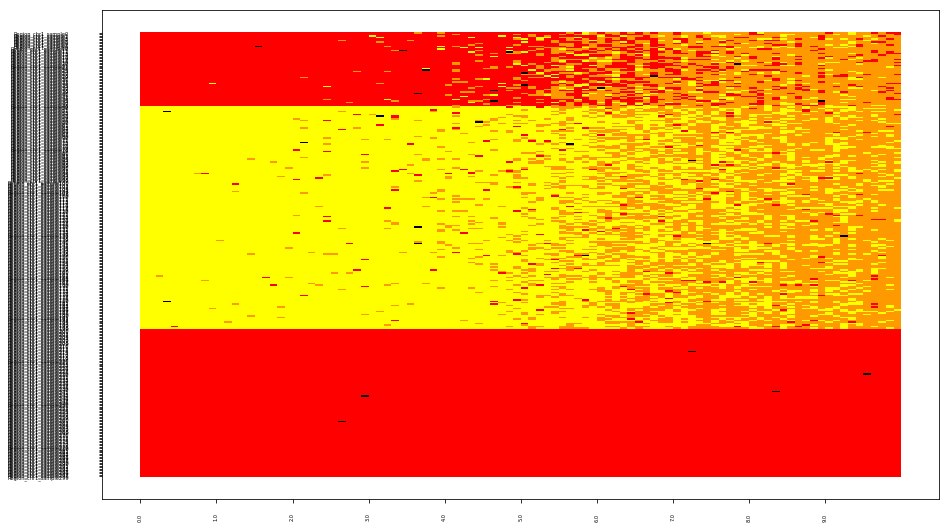

In [59]:
Comparison_threshold= 5
Outlier_threshold= 1e-4
color_ref= ['red','yellow','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks3 = Merge_class_mix(Windows_class,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

if not Mix_sizes:

    Ideo_KDE = []
    chromosome_list= []
    chromosomes= Blocks3.keys()

    for here in range(len(label_vector)):
        Subject = 'sample' + str(here)

        chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

        Stock = [[['Region_chr'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks3[Chr][bl][here] - 1]] for bl in sorted(Blocks3[Chr].keys())] for Chr in chromosomes]
        Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]

        Ideo_KDE.extend(Stock)

    #### begin by compressing assignments by individuals. Lightens the load of the following plot.
    import re
    ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

    # Filter out chromosomes not in our list
    ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

    ideo_kde = compress_ideo(ideo_kde,chromosome_list,Out)

    fig= return_ideogram(ideo_kde,chromosome_list,'kde',height=9,width= 15)


## Data analysis.



In [16]:
references= [0,1]
labels= [0,1]
Error_rate= {x:[] for x in target}

Global_error_rate= []

where= []


for bl in sorted(Blocks[1].keys()):
    label_indicies= label_indicies_bl[bl]
    ##everyone:
    non_outlier= [x for x in range(sum(Sizes)) if Blocks2[1][bl][x] != len(references) + 1]
    misshaps= [x for x in range(sum(Sizes)) if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] -1 in labels]
    rate= len(misshaps) / float(len(non_outlier))
    Global_error_rate.append(rate)

    
    for pop in label_indicies.keys():
        
        non_outlier= [x for x in label_indicies[pop] if Blocks2[1][bl][x] != len(labels) + 1]
        misshaps= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] -1 in labels]
        rate= len(misshaps) / float(len(non_outlier))
        Error_rate[pop].append(rate)
        where.append(bl)


tup= '01'
Xs= []
pop1= []
labels= []

for window in Windows_union.keys():
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])


coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T


fig_data= [go.Scatter(
#x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
#x= [min([datum[coords[z][x],1] for z in [0,1]]) / max([datum[coords[z][x],1] for z in [0,1]]) for x in range(len(Windows_union.keys()))],
x= [datum[coords[1-i][x],1] for x in range(len(Windows_union.keys()))],
#x= [datum[coords[i][x],1] - datum[coords[1-i][x],1] for x in range(len(Windows_union.keys()))],
#x= datum[coords[i],1],
#x= [Fst_crawl[x] for x in fst_indexes[fst_target]],
y= Error_rate[i],
name= "Error pop {}, P(Other | Pop {})".format(i,i),
mode= 'markers',
) for i in references
]


fig_data.append(go.Scatter(
#x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
#x= [sum([datum[coords[z][x],1] for z in [0,1]]) for x in range(len(Windows_union.keys()))],
#x= [datum[coords[i][x],1] for x in range(len(Windows_union.keys()))],
x= datum[coords['PU'],1],
y= Global_error_rate,
name= "Global",
mode= 'markers',
))


layout = go.Layout(
    title= 'Misassignment by overlap. Unimodal Cp = {}'.format(Comparison_threshold),
    yaxis=dict(
        range= [0,1],
        title='Error rate'),
        #title='Internal volume shared, P (Other | Pop)'),
    xaxis=dict(
        #title= 'Fst')
        title='Internal volume shared, P (Other | Pop)')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [19]:
labels= [0,1]
Error_rate= {x:[] for x in target}
Initial_error= {x:[] for x in target}
where= []
Intermediate_rate= {x:[] for x in target}
Info_loss= {x:[] for x in target}
Correction_rate= {x:[] for x in target}

Global_initial_error= []
Globl_initial_error= []
Global_error= []
Global_info_loss= []
Global_intermediate_rate= []
Global_correction_rate= []

for bl in Blocks3[1].keys():
    label_indicies= label_indicies_bl[bl]
    Swiss_range= range(len(Blocks3[1][bl]))
    non_outlier= [x for x in Swiss_range if Blocks3[1][bl][x] != len(labels) + 1]
    
    misshaps= [x for x in Swiss_range if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
    intermediates= [x for x in Swiss_range if Blocks3[1][bl][x] > len(labels)]

    Ori_miss= [x for x in Swiss_range if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] -1 in labels]
    loss= [x for x in intermediates if x not in Ori_miss]
    correction= [x for x in Ori_miss if x in intermediates]


    FirstSin= len(Ori_miss) / float(len(non_outlier))
    intimicy= len(intermediates) / float(len(non_outlier))
    rate= len(misshaps) / float(len(non_outlier))
    loss= len(loss) / float(len(non_outlier))

    if float(len(Ori_miss)) == 0:
        correction= 1
    else:
        correction= len(correction) / float(len(Ori_miss))

    Global_info_loss.append(loss)
    Globl_initial_error.append(FirstSin)
    Global_correction_rate.append(correction)
    Global_intermediate_rate.append(intimicy)
    Global_error.append(rate)
    where.append(bl)

    
    for pop in label_indicies.keys():
        
        non_outlier= [x for x in label_indicies[pop] if Blocks3[1][bl][x] != len(labels) + 1]
        misshaps= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
        intermediates= [x for x in label_indicies[pop] if Blocks3[1][bl][x] > len(labels)]
        
        Ori_miss= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] -1 in labels]
        loss= [x for x in intermediates if x not in Ori_miss]
        correction= [x for x in Ori_miss if x in intermediates]
        
        
        FirstSin= len(Ori_miss) / float(len(non_outlier))
        intimicy= len(intermediates) / float(len(non_outlier))
        rate= len(misshaps) / float(len(non_outlier))
        loss= len(loss) / float(len(non_outlier))
        
        if float(len(Ori_miss)) == 0:
            correction= 1
        else:
            correction= len(correction) / float(len(Ori_miss))
            
        Info_loss[pop].append(loss)
        Initial_error[pop].append(FirstSin)
        Correction_rate[pop].append(correction)
        Intermediate_rate[pop].append(intimicy)
        Error_rate[pop].append(rate)
        

tup= '01'
Xs= []
pop1= []
labels= []

for window in Windows_union.keys():
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])

coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T

fig_data= [go.Scatter(
x= [abs(datum[coords[i][x],1] - datum[coords[1-i][x],1]) for x in range(len(Windows_union.keys()))],
#x= [datum[coords[i][x],1] for x in range(len(Windows_union.keys()))],
#x= [Fst_crawl[x] for x in fst_indexes[fst_target]],
y= [Intermediate_rate[i][x] for x in range(len(Windows_union.keys()))],
#x= datum[coords[i],1],
mode= 'markers',
name= 'Pop {} error., P(Other | {})'.format(i,i)
) for i in [0,1]
]


fig_data.append(go.Scatter(
#x= [sum([datum[coords[z][x],1] for z in [0,1]]) for x in range(len(Windows_union.keys()))],
#x= [datum[coords[0][x],1] / datum[coords[1][x],1] for x in range(len(Windows_union.keys()))],
y= Global_intermediate_rate,
x= datum[coords['PU'],1],
name= 'Global',
mode= 'markers',
))

'''

'''
#### LOESS


####

layout = go.Layout(
    title= 'Intermediates by Fst. Unimodal. Cp = {}'.format(Comparison_threshold),
    yaxis=dict(
        range= [0,1.1],
        title='Intermediates'),
    xaxis=dict(
        #range= [0,1],
        title= 'Fst')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

## B. Frequency. *Changing proportion at a given pop without moving it about.*

### or, *Dominance over a particular branch.*

In this section we will perform supervised classification of structured reference populations overlapping at a given positition.

Overlap will be controlled by varying the proportion of samples from a single frequency vector labelled to each population.

Three frequency vectors are used. For two vectors sample labell will be left uniform, corresponding to the two reference populations. From the third vector the proportion of samples assigned to each reference will vary. Total number of samples from each vector will not vary.

In [20]:
Mix_sizes= False

labels= [0,1,2]
target= [0,1]
references= [0,1]

Sizes= [100,100,500]

Origins= {
    x:{
        y:[int(z == x) for z in range(len(Sizes))] for y in range(Sizes[x])
    } for x in range(len(Sizes))
}

import random

Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]
"""
Origins[len(Sizes) - 1]= {
    y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
}
"""

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}

d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        d += 1


In [ ]:
Proportion_range= np.arange(0,10,.1)

label_vector= np.repeat(labels,Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}
target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}

Pops= np.random.choice(vector_lib.shape[0],len(Sizes),replace= False)

label_vector_bl= recursively_default_dict()
label_indicies_bl= recursively_default_dict()
target_indx_bl= recursively_default_dict()


Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 1


Windows= recursively_default_dict()
Windows_class= recursively_default_dict()

Windows_union= recursively_default_dict()

#haplotypes= {x:[] for x in Whose}
Coordinates= recursively_default_dict()
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

threshold= .005
P= 30

current= recursively_default_dict()


for angle in Proportion_range:
    print(angle)
    if Mix_sizes:
        Sizes= np.random.choice(range(50,200),len(Sizes))

        Origins= {
            x:{
                y:[int(z == x) for z in range(len(Sizes))] for y in range(Sizes[x])
            } for x in range(len(Sizes))
        }

        import random

        Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]
        
        #### we can store these in a way that will facilitate later requests:
        
        Whose= []
        ind_to_group= {}

        d= 0
        for gp in Origins.keys():
            for acc in range(len(Origins[gp])):
                Whose.append(d)
                ind_to_group[d]= [gp,acc]
                d += 1
        
        label_vector= np.repeat(labels,Sizes)
        label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}
        target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
    
    coords= features[Pops,:]

    new_freqs= pca.inverse_transform(coords)
    
    #new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0

    N_pops= len(Pops)
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]

    data= []
    local_labels= []
    
    
    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(range(new_freqs.shape[0]), p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(range(new_freqs.shape[0]), p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        
        P_label= np.sin(angle) / 2 + .5
        
        if ind_to_group[acc][0] == 2:
            k= np.random.choice(references,p= [P_label,1-P_label])
        
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(labels[k] + 1)
    
    data= np.array(data)
    
    print(data.shape)
    
    '''
    if not Mix_sizes:
        for hap in range(data.shape[0]):
            haplotypes[hap].extend(data[hap,:])
    '''
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')
    
    data= pca2.fit_transform(data)
    
    ref_indicies= {z:[x for x in range(len(local_labels)) if local_labels[x] == z] for z in list(set(local_labels))}
    
    profiles_union= extract_profiles_union(data,ref_indicies,threshold,P)
    print([profiles_union[x]['PU'] for x in profiles_union.keys()])
    profiles_class= extract_profiles_class(data,ref_indicies)
    
    ##### FSTs
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([angle] * Pairwise.shape[0])

    ### store stuff.
    
    Coordinates[bl]= data[:,:3]
    
    label_vector_bl[bl]= label_vector
    label_indicies_bl[bl]= label_indicies
    target_indx_bl[bl]= target_indx
    
    Windows_class[bl]= profiles_class
    Blocks[1][bl]= local_labels
    Windows_union[bl]= profiles_union




Windows_class= {1:Windows_class}



In [22]:
# Plot overlaps
#Windows_union= recursively_default_dict()
fst_indexes= {z:[x for x in range(len(Fst_labels)) if Fst_labels[x] == z] for z in list(set(Fst_labels))}
fst_target= [z for z in fst_indexes.keys() if len([x for x in target if x in z]) == len(target)][0]

def plot_proximities(tup):
    Xs= []
    pop1= []
    labels= []
    
    for window in Windows_union.keys():
        Xs.extend([window] * 3)
        pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
        pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
        pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
        labels.extend(['P2|1','P1|2','Union'])
    
    coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}
    
    datum= np.array([Xs,pop1]).T
    
    fig_data= [go.Scatter(
    x= Proportion_range,
    y= datum[coords[i],1],
    mode= 'lines',
    name= i
    ) for i in coords.keys()
    ]
    layout = go.Layout(
        title= 'Variation between',
        yaxis=dict(
            title= 'volume',
            range=[0, 1]
        ),
        xaxis= dict(
            title= 'Fst'
        )
    )
    fig = go.Figure(data=fig_data, layout=layout)
    iplot(fig)



interact(plot_proximities, tup=['12'])

interactive(children=(Dropdown(description='tup', options=('12',), value='12'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_proximities>

In [23]:
Pairwise

,pops,fst
0,"(0, 1)",0.097245
1,"(0, 2)",0.075530
2,"(1, 2)",0.075416


In [24]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= [] 
chromosomes= [1]

### these are here for the names
Comparison_threshold= 1
Outlier_threshold= 1e-4

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

#ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


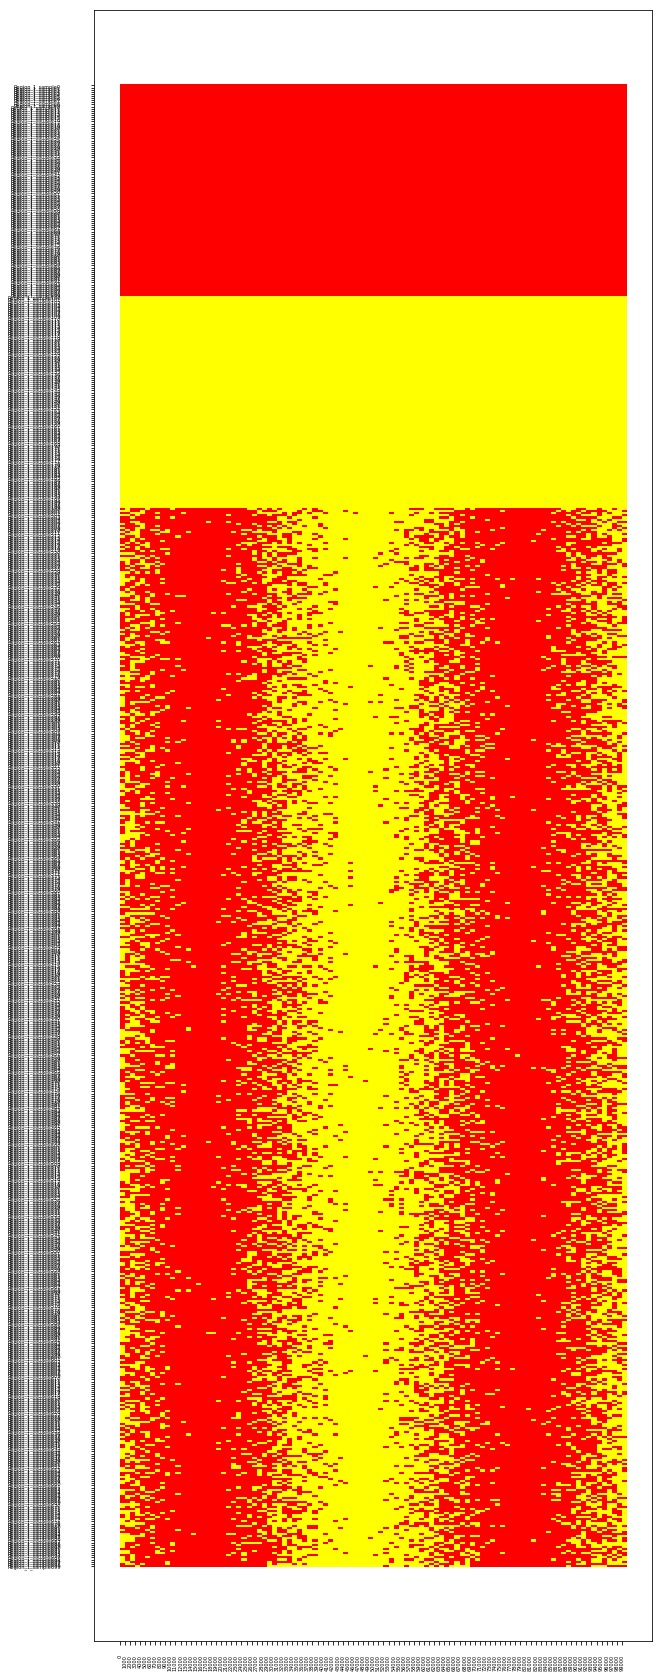

In [25]:
fig= return_ideogram(ideo,out= True)


1
number of reference populations: 2
1
number of reference populations: 2
adding ideograms...


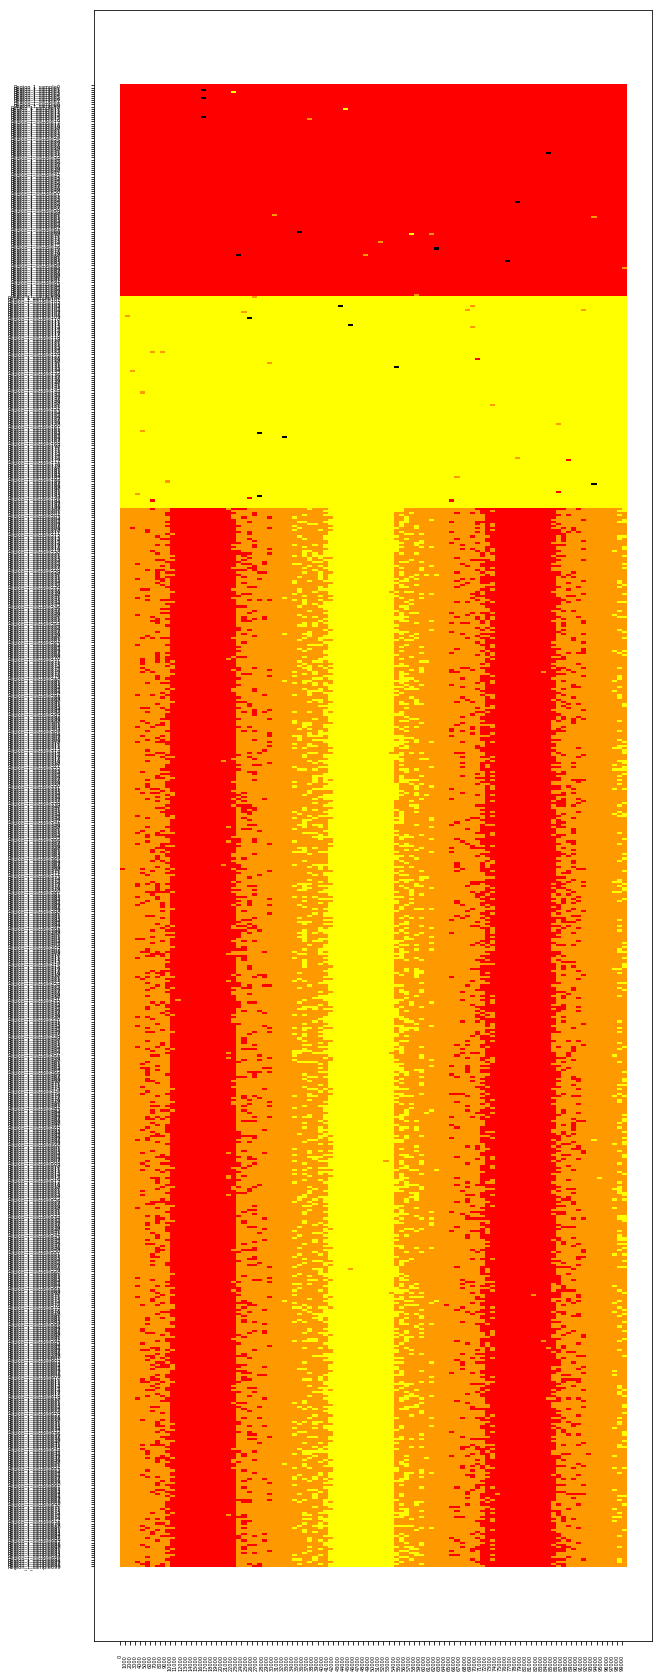

In [26]:
#### KDE no filter

import re
chromosome_list= [] 
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])



focus_indexes= [x for x in range(len(label_vector))]

# these are the ones you want to change.
Comparison_threshold= 4
Outlier_threshold= 1e-4

color_ref= ['red','yellow','black','orange','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class_mix(Windows_class,focus_indexes,Out,1,Outlier_threshold)

Blocks3 = Merge_class_mix(Windows_class,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

if not Mix_sizes:
    Ideo_KDE = []
    chromosome_list= []
    chromosomes= Blocks3.keys()

    for here in range(len(label_vector)):
        Subject = 'sample' + str(here)

        chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])

        Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks3[Chr][bl][here] - 1]] for bl in sorted(Blocks3[Chr].keys())] for Chr in chromosomes]
        Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]

        Ideo_KDE.extend(Stock)

    #### begin by compressing assignments by individuals. Lightens the load of the following plot.
    import re
    ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

    # Filter out chromosomes not in our list
    ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

    ideo_kde = compress_ideo(ideo_kde,chromosome_list)

    fig= return_ideogram(ideo_kde)


**Fig. Ideogram p-value threshold of choice**

## Data analysis.

During the simulation step, we extracted the volume overlap between reference populations and recorded the relative frequency of reference-specific haplotypes at the shared branch.

We can now analyse the classification output based on these statistics.

The first plot is interactive, and displays the positions of referrence specific haplotypes for the data set requested. Data set number is indicated at the bottom of the preceding ideograms.

In [27]:

### 
# Plot overlaps
#Windows_union= recursively_default_dict()
fst_indexes= {z:[x for x in range(len(Fst_labels)) if Fst_labels[x] == z] for z in list(set(Fst_labels))}
fst_target= [z for z in fst_indexes.keys() if len([x for x in target if x in z]) == len(target)][0]

def plot_proximities(bl):
    
    chains= {z:[x for x in range(len(Blocks[1][bl])) if Blocks2[1][bl][x] == z] for z in list(set(Blocks[1][bl]))}
    
    fig_data= [go.Scatter3d(
    x= Coordinates[bl][chains[i],0],
    y= Coordinates[bl][chains[i],1],
    z= Coordinates[bl][chains[i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 2,
        'symbol': 'circle',
        'color':i,
      "opacity": .6}
    ) for i in chains.keys()]
    
    layout = go.Layout(
        title= 'Variation between',
        yaxis=dict(
            title= 'volume',
            range=[0, 1]
        ),
        xaxis= dict(
            title= 'Fst'
        )
    )
    fig = go.Figure(data=fig_data)
    iplot(fig)



interact(plot_proximities, bl=[x for x in Blocks2[1].keys()])


interactive(children=(Dropdown(description='bl', options=(0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_proximities>

**Fig. PCA projection of haplotypes generated for requested data set.**

Let us also have a look at the relative frequencies of material from each reference at the shared branch along simulations.

In [37]:
labels= [0,1]
target= [2]
Error_rate= {x:[] for x in target}
Initial_error= {x:[] for x in target}
where= []
Intermediate_rate= {x:[] for x in target}
Info_loss= {x:[] for x in target}

Correction_rate= {x:[] for x in target}


for bl in Blocks3[1].keys():
    label_indicies= label_indicies_bl[bl]
    
    for pop in target:
        
        non_outlier= [x for x in label_indicies[pop] if Blocks3[1][bl][x] != len(labels) + 1]
        misshaps= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
        intermediates= [x for x in label_indicies[pop] if Blocks3[1][bl][x] > len(labels)]
        
        Ori_miss= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] -1 in labels]
        loss= [x for x in intermediates if x not in Ori_miss]
        correction= [x for x in Ori_miss if x in intermediates]
        
        
        FirstSin= len(Ori_miss) / float(len(non_outlier))
        intimicy= len(intermediates) / float(len(non_outlier))
        rate= len(misshaps) / float(len(non_outlier))
        loss= len(loss) / float(len(non_outlier))
        
        if float(len(Ori_miss)) == 0:
            correction= 1
        else:
            correction= len(correction) / float(len(Ori_miss))
            
        Info_loss[pop].append(loss)
        Initial_error[pop].append(FirstSin)
        Correction_rate[pop].append(correction)
        Intermediate_rate[pop].append(intimicy)
        Error_rate[pop].append(rate)
        where.append(bl)

tup= '12'
Xs= []
pop1= []
labels= []

for window in Windows_union.keys():
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])

coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T

freq1= [(Sizes[2] * (.5 + np.sin(angle) / 2)) / float(Sizes[2] * (.5 + np.sin(angle) / 2) + Sizes[0]) for angle in Proportion_range]
freq2= [(Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) / float((Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) + Sizes[1]) for angle in Proportion_range]

Combo= [freq1,freq2]

fig_data= [go.Scatter(
x= Proportion_range,
y= Combo[i],
name= "Pop {}".format(i),
mode= 'markers',
) for i in [0,1]
]


#### LOESS


####

layout = go.Layout(
    title= 'Label frequency',
    yaxis=dict(
        range= [0,1.1],
        title='Proportion'),
    xaxis=dict(
        title='Overlap')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

**Proportion of samples from mixed population labelled to each reference as a function of relative overlap.**

And finally study the relation between the variables we are interested in obtaining.

Here, the game is to understand the relation between relative overlap and classification output. We want to know how overlap impacts the number of errors and intermediate classificaiton. On the flip side, what proportion of haplotypes are classed into reference classes as a measure of relative overlap?

I have found the best descriptor of the probability of classification into a given class (pure or intermediate), to be the relative frequency of observations at the shared frequency. That is, the proportion of elements of one classs that are the shared source, divided by the proportion of elements from the other class that are found there as well. I believe this is because of some issues with the calculation of of overlap; but relative frequency is already an informative descriptor.



In [40]:

labels= [0,1,2]
Error_rate= {x:[] for x in labels if x not in references}
Global_error_rate= []
Global_intermediates= []
where= []

Pure_errors= {x:[] for x in labels if x in references}
Pure_assignment= {x:[] for x in labels if x in references}
Intermediate_rate= {x:[] for x in labels if x not in references}

for bl in Blocks[1].keys():
    label_indicies= label_indicies_bl[bl]
    
    ##everyone:
    non_outlier= [x for x in range(sum(Sizes)) if Blocks3[1][bl][x] != len(references) + 1]
    misshaps= [x for x in range(sum(Sizes)) if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
    intermediates= [x for x in range(sum(Sizes)) if Blocks3[1][bl][x] > len(labels)]
    
    intimicy= len(intermediates) / float(len(non_outlier))
    rate= len(misshaps) / float(len(non_outlier))
    
    Global_intermediates.append(intimicy)
    Global_error_rate.append(rate)

    
    
    origins_place= {z:[x for x in ind_to_group.keys() if ind_to_group[x][0] == z] for z in labels}
    for pop in references:
        non_outlier= [x for x in origins_place[2] if Blocks3[1][bl][x] != len(references) + 1]
        original= [x for x in non_outlier if Blocks2[1][bl][x] == pop + 1]
        
        error_by_pop= [x for x in original if Blocks3[1][bl][x] != pop + 1]
        
        if len(original) == 0:
            error_by_pop= 1
        else:
            error_by_pop= len(error_by_pop) / float(len(original))
        
        full_assignment= [x for x in non_outlier if Blocks3[1][bl][x] == pop + 1]
        full_assignment= len(full_assignment) / float(len(non_outlier))
        
        Pure_errors[pop].append(error_by_pop)
        Pure_assignment[pop].append(full_assignment)
        
    for pop in [x for x in label_indicies.keys() if x not in references]:
        
        non_outlier= [x for x in label_indicies[pop] if Blocks3[1][bl][x] != len(references) + 1]
        misshaps= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
        intermediates= [x for x in label_indicies[pop] if Blocks3[1][bl][x] > len(labels)]
        intimicy= len(intermediates) / float(len(non_outlier))
        rate= len(misshaps) / float(len(non_outlier))
        
        Intermediate_rate[pop].append(intimicy)
        Error_rate[pop].append(rate)
        where.append(bl)


tup= '12'
Xs= []
pop1= []
labels= []

for window in sorted(Windows_union.keys()):
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])

coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T



freqs= {u:[[angle / len(Proportion_range) * 10,1-(angle / len(Proportion_range) * 10)][u] * Sizes[2] / \
           (sum([Sizes[u],[angle / len(Proportion_range) * 10,1-(angle / len(Proportion_range) * 10)][u] * Sizes[2]])) for angle in Proportion_range] for u in [0,1]}

freq1= [(Sizes[2] * (.5 + np.sin(angle) / 2)) / float(Sizes[2] * (.5 + np.sin(angle) / 2) + Sizes[0]) for angle in Proportion_range]
freq2= [(Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) / float((Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) + Sizes[1]) for angle in Proportion_range]

Combo= [freq1,freq2]
Frequency_differences= [min([Combo[u][x] for u in range(len(Combo))]) / max([Combo[u][x] for u in range(len(Combo))]) for x in range(len(Combo[0]))]
Freq_0= [Combo[0][x] / Combo[1][x] for x in range(len(Combo[0]))]


PU_threshold= .4
PU_high= [int(datum[coords['PU'],1][x] > PU_threshold) for x in range(len(datum[coords['PU'],1]))]
PU_indexes= {z:[x for x in range(len(PU_high)) if PU_high[x] == z] for z in [0,1]}


Error_threshold= .3
Error_high= [int(x > Error_threshold) for x in Global_error_rate]
Error_indexes= {z:[x for x in range(len(Error_high)) if Error_high[x] == z] for z in [0,1]}



fig_data= [go.Scatter(
#x= [(.5 + angle *  .5 / len(Proportion_range) * 10) / (.5 - angle *  .5 / len(Proportion_range) * 10)  for angle in Proportion_range],
#x= [Frequency_differences[x] for x in Error_indexes[i]],
#x= [np.log(Freq_0[x])  for x in Error_indexes[i]],
#x= Freq_0,
#x= [sum([Combo[z][x] for z in range(len(Combo))]) for x in Error_indexes[i]],
#x= [np.sin(angle) / 2 + .5 for angle in Proportion_range],
#x= [angle *  .5 / len(Proportion_range) * 10 for angle in Proportion_range],
#x= [max([datum[coords[z][x],1] for z in [0,1]]) for x in range(len(Windows_union.keys()))],
#x= [datum[coords[i][x],1] for x in range(len(Windows_union.keys()))],
#x= [datum[coords['PU'],1][x] for x in Error_indexes[i]],
#x= datum[coords['PU'],1],
x= [max([datum[coords[i][x],1],datum[coords[1-i][x],1]]) for x in range(len(Windows_union.keys()))],
#y= [Pure_assignment[0][x] for x in Error_indexes[i]],
#y= Pure_assignment[i],
y= [Intermediate_rate[2][x] for x in Error_indexes[i]],
mode= 'markers',
name= "Error {} {}".format(['<','>'][i],Error_threshold),
marker= dict(
    color= ['grey','red'][i]
)
) for i in [0]
]


layout = go.Layout(
    title= 'Intermediate assignment and max local overlap. Cp threshold= {}'.format([Comparison_threshold,'None'][int(Comparison_threshold <= 1)]),
    yaxis=dict(
        range= [0,1.1],
        title='Intermediate Assignment (%)'),
    xaxis=dict(
        #range= [0,.5],
        title='maximum overlap')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [44]:

labels= [0,1,2]
Error_rate= {x:[] for x in labels if x not in references}
Global_error_rate= []
Global_intermediates= []
where= []

Pure_errors= {x:[] for x in labels if x in references}
Pure_assignment= {x:[] for x in labels if x in references}
Intermediate_rate= {x:[] for x in labels if x not in references}

for bl in Blocks[1].keys():
    label_indicies= label_indicies_bl[bl]
    
    ##everyone:
    non_outlier= [x for x in range(sum(Sizes)) if Blocks3[1][bl][x] != len(references) + 1]
    misshaps= [x for x in range(sum(Sizes)) if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
    intermediates= [x for x in range(sum(Sizes)) if Blocks3[1][bl][x] > len(labels)]
    
    intimicy= len(intermediates) / float(len(non_outlier))
    rate= len(misshaps) / float(len(non_outlier))
    
    Global_intermediates.append(intimicy)
    Global_error_rate.append(rate)

    
    
    origins_place= {z:[x for x in ind_to_group.keys() if ind_to_group[x][0] == z] for z in labels}
    for pop in references:
        non_outlier= [x for x in origins_place[2] if Blocks3[1][bl][x] != len(references) + 1]
        original= [x for x in non_outlier if Blocks2[1][bl][x] == pop + 1]
        
        error_by_pop= [x for x in original if Blocks3[1][bl][x] != pop + 1]
        
        if len(original) == 0:
            error_by_pop= 1
        else:
            error_by_pop= len(error_by_pop) / float(len(original))
        
        full_assignment= [x for x in non_outlier if Blocks3[1][bl][x] == pop + 1]
        full_assignment= len(full_assignment) / float(len(non_outlier))
        
        Pure_errors[pop].append(error_by_pop)
        Pure_assignment[pop].append(full_assignment)
        
    for pop in [x for x in label_indicies.keys() if x not in references]:
        
        non_outlier= [x for x in label_indicies[pop] if Blocks3[1][bl][x] != len(references) + 1]
        misshaps= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
        intermediates= [x for x in label_indicies[pop] if Blocks3[1][bl][x] > len(labels)]
        intimicy= len(intermediates) / float(len(non_outlier))
        rate= len(misshaps) / float(len(non_outlier))
        
        Intermediate_rate[pop].append(intimicy)
        Error_rate[pop].append(rate)
        where.append(bl)


tup= '12'
Xs= []
pop1= []
labels= []

for window in sorted(Windows_union.keys()):
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])

coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T



freqs= {u:[[angle / len(Proportion_range) * 10,1-(angle / len(Proportion_range) * 10)][u] * Sizes[2] / \
           (sum([Sizes[u],[angle / len(Proportion_range) * 10,1-(angle / len(Proportion_range) * 10)][u] * Sizes[2]])) for angle in Proportion_range] for u in [0,1]}

freq1= [(Sizes[2] * (.5 + np.sin(angle) / 2)) / float(Sizes[2] * (.5 + np.sin(angle) / 2) + Sizes[0]) for angle in Proportion_range]
freq2= [(Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) / float((Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) + Sizes[1]) for angle in Proportion_range]

Combo= [freq1,freq2]
Frequency_differences= [min([Combo[u][x] for u in range(len(Combo))]) / max([Combo[u][x] for u in range(len(Combo))]) for x in range(len(Combo[0]))]
Freq_0= [Combo[0][x] / Combo[1][x] for x in range(len(Combo[0]))]


PU_threshold= .4
PU_high= [int(datum[coords['PU'],1][x] > PU_threshold) for x in range(len(datum[coords['PU'],1]))]
PU_indexes= {z:[x for x in range(len(PU_high)) if PU_high[x] == z] for z in [0,1]}


Error_threshold= .3
Error_high= [int(x > Error_threshold) for x in Global_error_rate]
Error_indexes= {z:[x for x in range(len(Error_high)) if Error_high[x] == z] for z in [0,1]}



fig_data= [go.Scatter(
#x= [(.5 + angle *  .5 / len(Proportion_range) * 10) / (.5 - angle *  .5 / len(Proportion_range) * 10)  for angle in Proportion_range],
x= [Frequency_differences[x] for x in Error_indexes[i]],
#x= [np.log(Freq_0[x])  for x in Error_indexes[i]],
#x= Freq_0,
#x= [sum([Combo[z][x] for z in range(len(Combo))]) for x in Error_indexes[i]],
#x= [np.sin(angle) / 2 + .5 for angle in Proportion_range],
#x= [angle *  .5 / len(Proportion_range) * 10 for angle in Proportion_range],
#x= [max([datum[coords[z][x],1] for z in [0,1]]) for x in range(len(Windows_union.keys()))],
#x= [datum[coords[i][x],1] for x in range(len(Windows_union.keys()))],
#x= [datum[coords['PU'],1][x] for x in Error_indexes[i]],
#x= datum[coords['PU'],1],
#x= [datum[coords[i][x],1] / datum[coords[1-i][x],1] for x in range(len(Windows_union.keys()))],
#y= [Pure_assignment[0][x] for x in Error_indexes[i]],
#y= Pure_assignment[i],
y= [Intermediate_rate[2][x] for x in Error_indexes[i]],
mode= 'markers',
name= "Error {} {}".format(['<','>'][i],Error_threshold),
marker= dict(
    color= ['grey','red'][i]
)
) for i in [0]
]


layout = go.Layout(
    title= 'Intermediate assignment and relative frequency. Cp threshold= {}'.format([Comparison_threshold,'None'][int(Comparison_threshold <= 1)]),
    yaxis=dict(
        range= [0,1.1],
        title='Intermediate Assignment (%)'),
    xaxis=dict(
        #range= [0,.5],
        title= "relative frequency.")
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [43]:

labels= [0,1,2]
Error_rate= {x:[] for x in labels if x not in references}
Global_error_rate= []
Global_intermediates= []
where= []

Pure_errors= {x:[] for x in labels if x in references}
Pure_assignment= {x:[] for x in labels if x in references}
Intermediate_rate= {x:[] for x in labels if x not in references}

for bl in Blocks[1].keys():
    label_indicies= label_indicies_bl[bl]
    
    ##everyone:
    non_outlier= [x for x in range(sum(Sizes)) if Blocks3[1][bl][x] != len(references) + 1]
    misshaps= [x for x in range(sum(Sizes)) if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
    intermediates= [x for x in range(sum(Sizes)) if Blocks3[1][bl][x] > len(labels)]
    
    intimicy= len(intermediates) / float(len(non_outlier))
    rate= len(misshaps) / float(len(non_outlier))
    
    Global_intermediates.append(intimicy)
    Global_error_rate.append(rate)

    
    
    origins_place= {z:[x for x in ind_to_group.keys() if ind_to_group[x][0] == z] for z in labels}
    for pop in references:
        non_outlier= [x for x in origins_place[2] if Blocks3[1][bl][x] != len(references) + 1]
        original= [x for x in non_outlier if Blocks2[1][bl][x] == pop + 1]
        
        error_by_pop= [x for x in original if Blocks3[1][bl][x] != pop + 1]
        
        if len(original) == 0:
            error_by_pop= 1
        else:
            error_by_pop= len(error_by_pop) / float(len(original))
        
        full_assignment= [x for x in non_outlier if Blocks3[1][bl][x] == pop + 1]
        full_assignment= len(full_assignment) / float(len(non_outlier))
        
        Pure_errors[pop].append(error_by_pop)
        Pure_assignment[pop].append(full_assignment)
        
    for pop in [x for x in label_indicies.keys() if x not in references]:
        
        non_outlier= [x for x in label_indicies[pop] if Blocks3[1][bl][x] != len(references) + 1]
        misshaps= [x for x in label_indicies[pop] if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] -1 in labels]
        intermediates= [x for x in label_indicies[pop] if Blocks3[1][bl][x] > len(labels)]
        intimicy= len(intermediates) / float(len(non_outlier))
        rate= len(misshaps) / float(len(non_outlier))
        
        Intermediate_rate[pop].append(intimicy)
        Error_rate[pop].append(rate)
        where.append(bl)


tup= '12'
Xs= []
pop1= []
labels= []

for window in sorted(Windows_union.keys()):
    Xs.extend([window] * 4)
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[0])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))][int(tup[1])])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['empty'])
    pop1.append(Windows_union[window][tuple((int(tup[0]),int(tup[1])))]['PU'])
    labels.extend([0,1,'leftover space','PU'])

coords= {i:[x for x in range(len(labels)) if labels[x] == i] for i in list(set(labels))}

datum= np.array([Xs,pop1]).T



freqs= {u:[[angle / len(Proportion_range) * 10,1-(angle / len(Proportion_range) * 10)][u] * Sizes[2] / \
           (sum([Sizes[u],[angle / len(Proportion_range) * 10,1-(angle / len(Proportion_range) * 10)][u] * Sizes[2]])) for angle in Proportion_range] for u in [0,1]}

freq1= [(Sizes[2] * (.5 + np.sin(angle) / 2)) / float(Sizes[2] * (.5 + np.sin(angle) / 2) + Sizes[0]) for angle in Proportion_range]
freq2= [(Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) / float((Sizes[2] - Sizes[2] * (.5 + np.sin(angle) / 2)) + Sizes[1]) for angle in Proportion_range]

Combo= [freq1,freq2]
Frequency_differences= [min([Combo[u][x] for u in range(len(Combo))]) / max([Combo[u][x] for u in range(len(Combo))]) for x in range(len(Combo[0]))]
Freq_0= [Combo[0][x] / Combo[1][x] for x in range(len(Combo[0]))]


PU_threshold= .4
PU_high= [int(datum[coords['PU'],1][x] > PU_threshold) for x in range(len(datum[coords['PU'],1]))]
PU_indexes= {z:[x for x in range(len(PU_high)) if PU_high[x] == z] for z in [0,1]}


Error_threshold= .3
Error_high= [int(x > Error_threshold) for x in Global_error_rate]
Error_indexes= {z:[x for x in range(len(Error_high)) if Error_high[x] == z] for z in [0,1]}



fig_data= [go.Scatter(
#x= [(.5 + angle *  .5 / len(Proportion_range) * 10) / (.5 - angle *  .5 / len(Proportion_range) * 10)  for angle in Proportion_range],
#x= [Frequency_differences[x] for x in Error_indexes[i]],
x= [np.log(Freq_0[x])  for x in Error_indexes[i]],
#x= Freq_0,
#x= [sum([Combo[z][x] for z in range(len(Combo))]) for x in Error_indexes[i]],
#x= [np.sin(angle) / 2 + .5 for angle in Proportion_range],
#x= [angle *  .5 / len(Proportion_range) * 10 for angle in Proportion_range],
#x= [max([datum[coords[z][x],1] for z in [0,1]]) for x in range(len(Windows_union.keys()))],
#x= [datum[coords[i][x],1] for x in range(len(Windows_union.keys()))],
#x= [datum[coords['PU'],1][x] for x in Error_indexes[i]],
#x= datum[coords['PU'],1],
#x= [max([datum[coords[i][x],1],datum[coords[1-i][x],1]]) for x in range(len(Windows_union.keys()))],
y= [Pure_assignment[0][x] for x in Error_indexes[i]],
#y= Pure_assignment[i],
#y= [Intermediate_rate[2][x] for x in Error_indexes[i]],
mode= 'markers',
name= "Error {} {}".format(['<','>'][i],Error_threshold),
marker= dict(
    color= ['grey','red'][i]
)
) for i in [0]
]


layout = go.Layout(
    title= 'Pure assignment and log relative frequency. Cp threshold= {}'.format([Comparison_threshold,'None'][int(Comparison_threshold <= 1)]),
    yaxis=dict(
        range= [0,1.1],
        #title='Intermediate Assignment (%)'),
        title= 'Pure assignment (%)'),
    xaxis=dict(
        #range= [0,.5],
        #title= 'Total Overlap'),
        title= "log relative frequency.")
        #title='maximum frequency')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)